# Randomized Tensor Games Experiments

Эксперименты с рандомизированными тензорными играми, где равновесия на диагонали имеют высокую дисперсию.

In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensor_games import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Создание рандомизированной тензорной игры

In [107]:

n_actions = 5
n_players = 3
base_payoffs = 5*np.arange(0,n_actions) + 10

random_game = create_probabilistic_game_with_lower_offdiag(
    n_players=n_players,
    n_actions=n_actions,
    base_values=base_payoffs,
    diag_variance=1.0,
    off_diag_variance=3.0,
    off_diag_base_upper_bound= min(base_payoffs)  # меньше минимального диагонального (8)
)

some_actions = np.random.choice(np.arange(1, n_actions), size  = (n_players, ))

random_game.get_payoffs( some_actions) , random_game.n_actions

([12.719564090535794, 2.4953181974538956, 0.8716830759589129], (5, 5, 5))

## 2. Визуализация рандомизированной игры

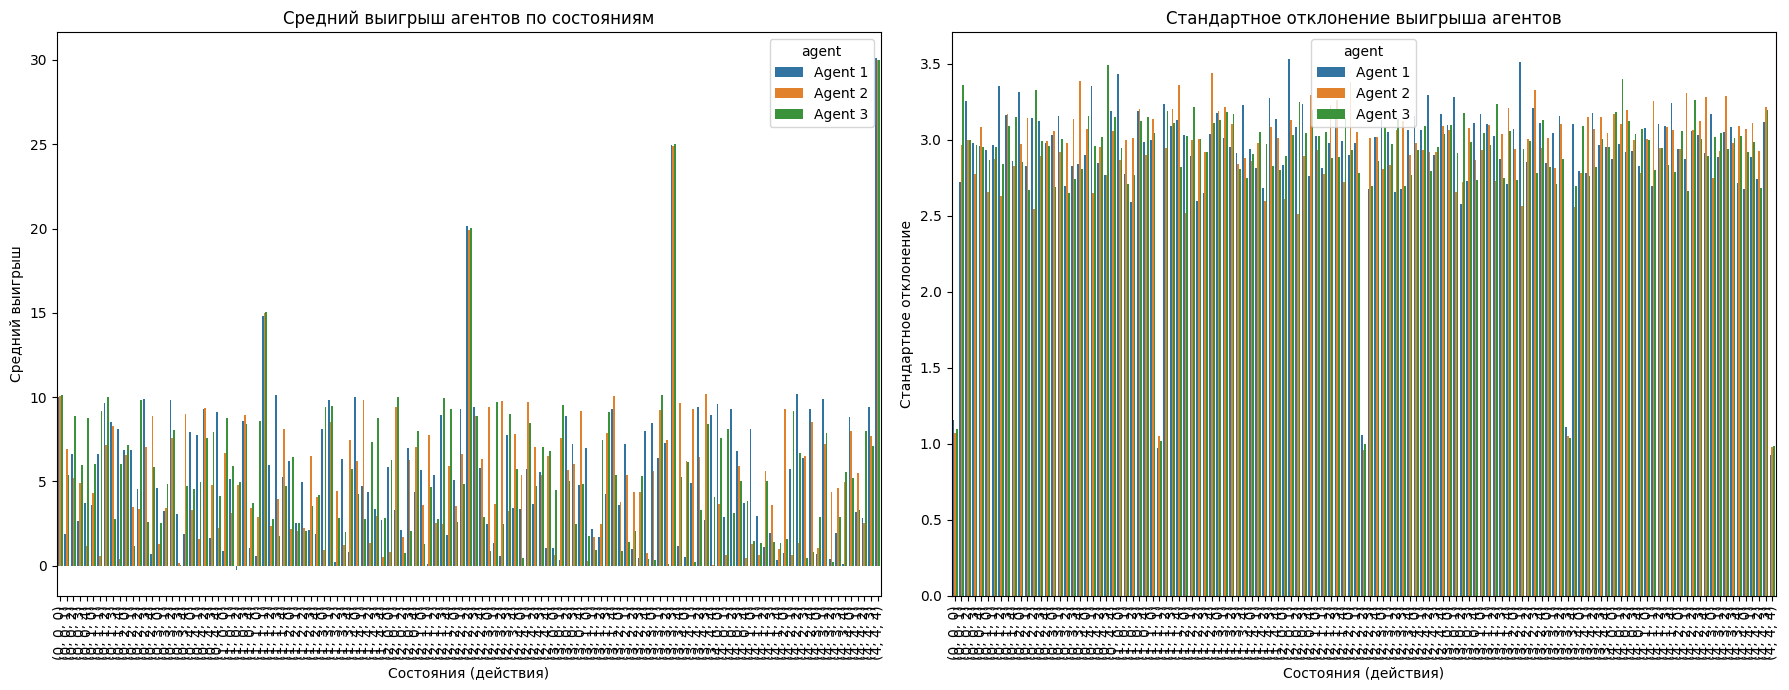

In [108]:
stats_df = collect_statistics(random_game, n_samples=100)
plot_stats_barplot(stats_df)

## 3. Обучение агентов, последний агент -- варьируем

In [119]:
def run_experiment_on_my_agent(
    game: TensorGame,
    n_players: int,
    my_agent_kwargs: dict,
    n_episodes: int = 1000,
    verbose: bool = False
):
    # Остальные агенты — фиксированные
    agents = []
    for _ in range(n_players - 1):
        agent = MultiAgent(n_actions=game.n_actions[0], lr=1e-3, epsilon=0.0, optimizer_type='Adam')
        agents.append(agent)

    # Последний агент с настраиваемыми параметрами
    my_agent = MultiAgent(n_actions=game.n_actions[0], **my_agent_kwargs)
    agents.append(my_agent)

    # Обучение
    history = train_multi_agents(game, agents, n_episodes=n_episodes)

    # Сбор результатов
    final_strategies = [agent.get_action_probs() for agent in agents]
    final_rewards = np.mean(history[-100:], axis=0)
    most_likely_actions = [np.argmax(strategy) for strategy in final_strategies]

    if verbose:
        print("\nФинальные стратегии:")
        for i, strategy in enumerate(final_strategies):
            print(f"Агент {i+1}: {[f'{p:.3f}' for p in strategy]}")
        print(f"\nСредние награды за последние 100 эпизодов:")
        for i, reward in enumerate(final_rewards):
            print(f"Агент {i+1}: {reward:.3f}")
        print(f"Общая сумма: {sum(final_rewards):.3f}")
        print(f"\nНаиболее вероятные действия: {most_likely_actions}")

    return {
        "history": history,
        "final_rewards": final_rewards,
        "final_strategies": final_strategies,
        "most_likely_actions": most_likely_actions
    }


## 4. Визуализация обучения

In [122]:
configs = [
    {"optimizer_type": "Adam", "lr": 1e-3, "epsilon": 0.0},
    {"optimizer_type": "SGD",  "lr": 1e-2, "epsilon": 0.0},
    {"optimizer_type": "Adam", "lr": 1e-2, "epsilon": 0.1},
    {"optimizer_type": "Adam", "lr": 5e-4, "epsilon": 0.2},
]

results = []

for config in configs:
    print(f"\n🚀 Запуск с параметрами: {config}")
    res = run_experiment_on_my_agent(random_game, n_players=3, my_agent_kwargs=config, n_episodes=10000)
    results.append((config, res))



🚀 Запуск с параметрами: {'optimizer_type': 'Adam', 'lr': 0.001, 'epsilon': 0.0}
Episode 0: Avg rewards ['19.392', '21.102', '19.702']
Episode 1000: Avg rewards ['23.217', '22.952', '22.904']
Episode 2000: Avg rewards ['25.055', '25.010', '25.097']
Episode 3000: Avg rewards ['24.971', '25.081', '24.998']
Episode 4000: Avg rewards ['25.061', '24.993', '24.851']
Episode 5000: Avg rewards ['25.068', '24.801', '24.907']
Episode 6000: Avg rewards ['25.138', '25.112', '25.196']
Episode 7000: Avg rewards ['25.168', '24.948', '25.031']
Episode 8000: Avg rewards ['25.037', '25.039', '24.962']
Episode 9000: Avg rewards ['24.888', '24.912', '24.836']

🚀 Запуск с параметрами: {'optimizer_type': 'SGD', 'lr': 0.01, 'epsilon': 0.0}
Episode 0: Avg rewards ['4.557', '2.597', '11.461']
Episode 1000: Avg rewards ['8.384', '8.507', '7.801']
Episode 2000: Avg rewards ['8.815', '9.052', '9.249']
Episode 3000: Avg rewards ['9.432', '9.090', '8.773']
Episode 4000: Avg rewards ['9.011', '9.092', '8.996']
Episo

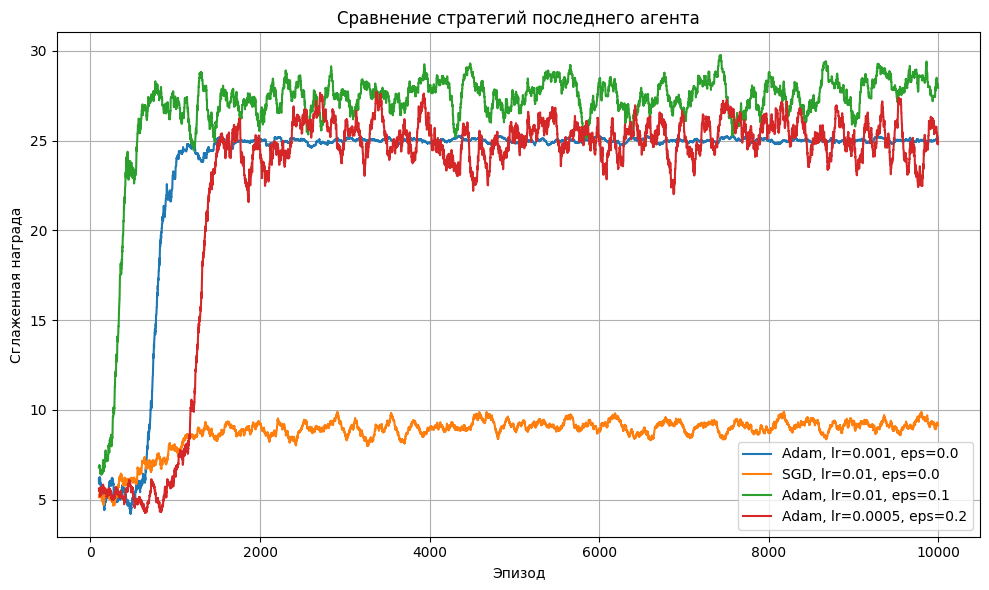

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for config, res in results:
    label = f"{config['optimizer_type']}, lr={config['lr']}, eps={config['epsilon']}"
    rewards = [r[-1] for r in res["history"]]  # payoff последнего агента
    smoothed = pd.Series(rewards).rolling(window=100).mean()
    plt.plot(smoothed, label=label)

plt.title("Сравнение стратегий последнего агента")
plt.xlabel("Эпизод")
plt.ylabel("Сглаженная награда")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


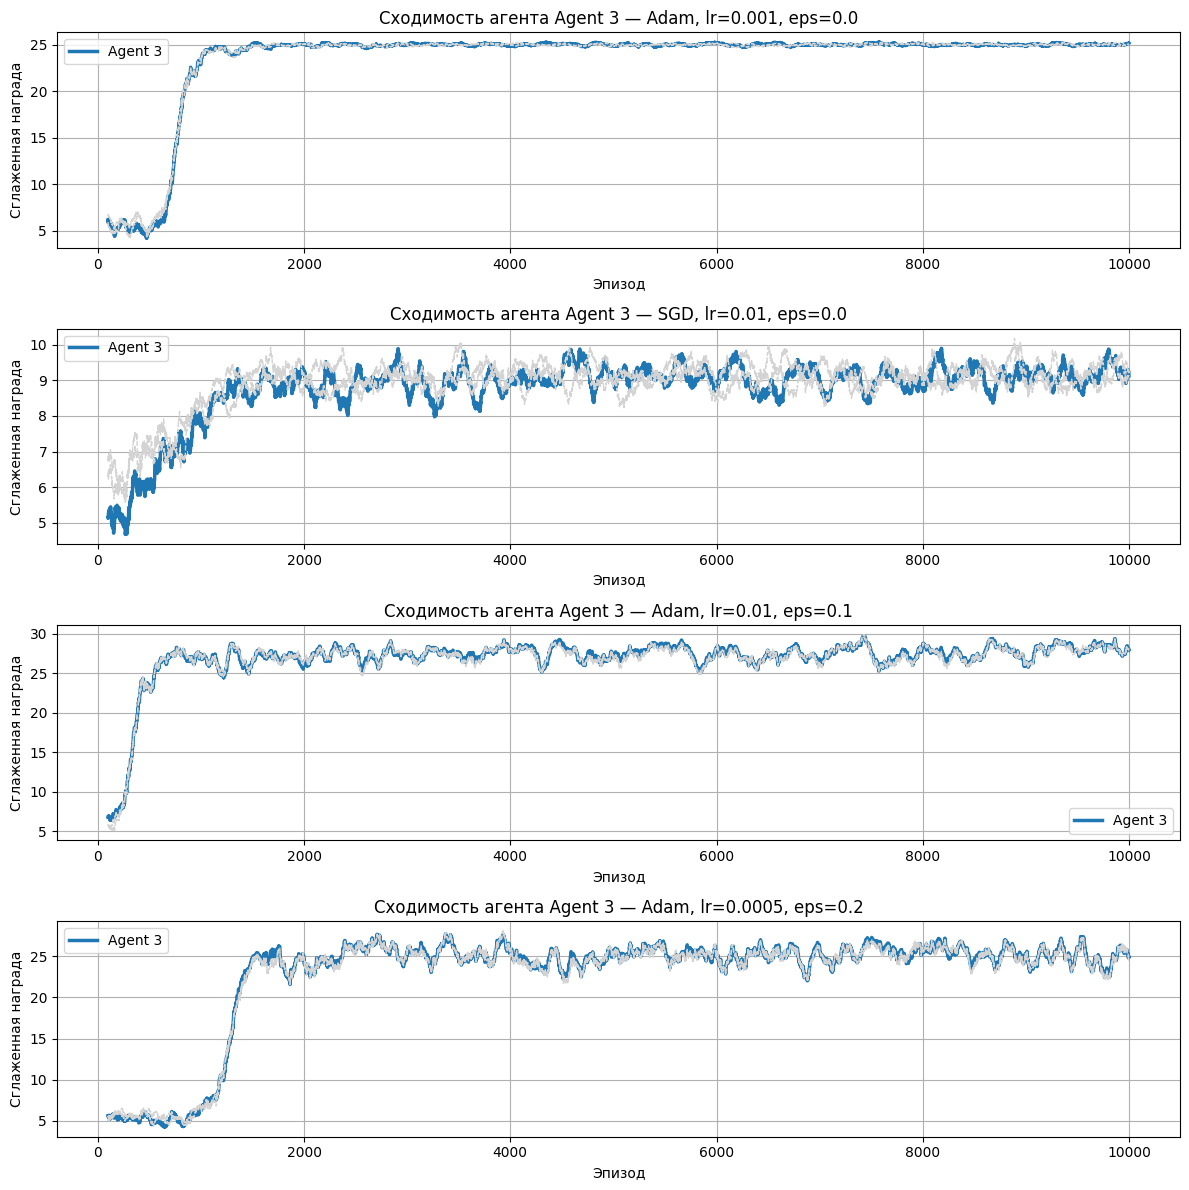

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_comparative_convergence(results, agent_index: int = -1, window_size: int = 100):
    """
    results: список кортежей (config_dict, result_dict)
    agent_index: индекс агента, которого мы варьируем (по умолчанию последний)
    """
    plt.figure(figsize=(12, len(results) * 3))

    for i, (config, res) in enumerate(results, start=1):
        history = res["history"]
        df = pd.DataFrame(history, columns=[f'Agent {j+1}' for j in range(len(history[0]))])
        df_smooth = df.rolling(window=window_size).mean()

        plt.subplot(len(results), 1, i)
        
        # Агент, которого варьируем
        key_agent = df_smooth.columns[agent_index]
        plt.plot(df_smooth[key_agent], label=key_agent, linewidth=2.5)

        # Остальные агенты — тонкими серыми линиями
        for col in df_smooth.columns:
            if col != key_agent:
                plt.plot(df_smooth[col], color='lightgray', linestyle='--', linewidth=1)

        # Подписи и оформление
        label = f"{config['optimizer_type']}, lr={config['lr']}, eps={config['epsilon']}"
        plt.title(f"Сходимость агента {key_agent} — {label}")
        plt.xlabel("Эпизод")
        plt.ylabel("Сглаженная награда")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()
plot_comparative_convergence(results)
